<a href="https://colab.research.google.com/github/abhigyan13/Image_colorization_with_GANS/blob/main/colorization_with_GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
import time
import os
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import glob
from PIL import Image
import pickle
import shutil
import matplotlib.pyplot as plt


dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available()==False:
  dtype=torch.FloatTensor
print(device,dtype)

cuda <class 'torch.cuda.FloatTensor'>


**Generator Model**

In [61]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.c1 = nn.Sequential(nn.Conv2d(  1, 64,1, bias=False  ) , nn.LeakyReLU(0.2))
    self.c2 = nn.Sequential(nn.Conv2d( 64, 64,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(64 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c3 = nn.Sequential(nn.Conv2d( 64,128,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(128 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c4 = nn.Sequential(nn.Conv2d(128,256,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(256 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c5 = nn.Sequential(nn.Conv2d(256,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c6 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c7 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c8 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.dconv7 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1, bias=False)
    self.bn_relu7 = nn.Sequential(nn.BatchNorm2d(1024 , momentum = 0.5) , nn.ReLU(inplace = True ))
    self.dconv6 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False)
    self.bn_relu6 = nn.Sequential(nn.BatchNorm2d(1024 , momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv5 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False)
    self.bn_relu5 = nn.Sequential(nn.BatchNorm2d(1024 , momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv4 = nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1, bias=False)
    self.bn_relu4 = nn.Sequential(nn.BatchNorm2d(512, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv3 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1, bias=False)
    self.bn_relu3 = nn.Sequential(nn.BatchNorm2d(256, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1, bias=False)
    self.bn_relu2 = nn.Sequential(nn.BatchNorm2d(128, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
    self.bn_relu1 = nn.Sequential(nn.BatchNorm2d(128, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.final = nn.Conv2d(128 , 2 , 1 , bias = False )
    self.Tanh = nn.Tanh()

  def forward(self , x):
    out = x
    out = self.c1(out)
    p1 = out
    out = self.c2(out)
    p2 = out
    out = self.c3(out)
    p3 = out
    out = self.c4(out)
    p4 = out
    out = self.c5(out)
    p5 = out
    out = self.c6(out)
    p6 = out
    out = self.c7(out)
    p7 = out
    out = self.c8(out)
    out = self.dconv7(out)
    out = torch.cat((out , p7) , 1 )
    out = self.bn_relu7(out)
    
    out = self.dconv6(out)
    out = torch.cat((out , p6) , 1 )
    out = self.bn_relu6(out)
    
    out = self.dconv5(out)
    out = torch.cat((out , p5) , 1 )
    out = self.bn_relu5(out)
    
    out = self.dconv4(out)
    out = torch.cat((out , p4) , 1 )
    out = self.bn_relu4(out)
    
    out = self.dconv3(out)
    out = torch.cat((out , p3) , 1 )
    out = self.bn_relu3(out)
    
    out = self.dconv2(out)
    out = torch.cat((out , p2) , 1 )
    out = self.bn_relu2(out)
    
    out = self.dconv1(out)
    out = torch.cat((out , p1) , 1 )
    out = self.bn_relu1(out)
    
    out = self.final(out)
    out = self.Tanh(out)
    return out

  def initialize_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()


  
    




**Discriminator Model**

In [62]:
class Discriminator(nn.Module):

  def __init__(self , mode = 'train'):
    
    super().__init__()
    self.mode = mode
    self.c1 = nn.Sequential(nn.Conv2d(  3 , 64,1, bias=False  ) , nn.LeakyReLU(0.2))
    self.c2 = nn.Sequential(nn.Conv2d( 64, 64,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(64 ,  momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c3 = nn.Sequential(nn.Conv2d( 64,128,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(128 ,  momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c4 = nn.Sequential(nn.Conv2d(128,256,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(256 , momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c5 = nn.Sequential(nn.Conv2d(256,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c6 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c7 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c8 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.flat=nn.Flatten()
    self.fc1=nn.Linear(2048,100)
    self.relu9=nn.LeakyReLU(0.2)
    self.fc2=nn.Linear(100,1)

  def forward(self , x ):
    out = x
    out = self.c1(out)
    out = self.c2(out)
    out = self.c3(out)
    out = self.c4(out)
    out = self.c5(out)
    out = self.c6(out)
    out = self.c7(out)
    out = self.c8(out)
    out = self.flat(out)
    out = self.fc1(out)
    out = self.relu9(out)
    out = self.fc2(out)
    out = torch.sigmoid(out)
    return out

  def initialize_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()
        if isinstance(module,nn.Linear):
          nn.init.xavier_uniform_(module.weight.data)




**Set configuration by calling an instance of set_config class** 

In [63]:
class set_config:

  def __init__(self):
    self.cuda=torch.cuda.is_available()
    self.weight_decay=0 
    self.lr=0.00009 
    self.test_img = None
    self.batch_size = 8 
    self.mode='train'
    self.resume= True
    self.path='/content/drive/MyDrive/colorization/'
    self.lambd =100
    self.epoch_ul = 60
    self.gpath= self.path+ 'weights/'
    self.dpath = self.path+'weights/'
    self.loss_path = '/content/drive/MyDrive/colorization/loss_history/'
    self.save_test = True

cfg=set_config() 

**Data Loader and Pre-Processing**

In [64]:
class Places365_loader(data.Dataset):
  def __init__(self , mode = 'train' , path = '/content/drive/MyDrive/colorization/' ):
    self.mode = mode
    if(mode == 'train'):
      path = '/content/drive/MyDrive/colorization/dataset/' 
      self.image_path = glob.glob(path+'train/*.*')
    elif mode == 'test':
      self.test_path = path 

  def __getitem__(self , index ):
    if self.mode == 'test':
      image = cv2.imread(self.test_path)
      image = cv2.resize(image , (256,256))
    else:
      image = cv2.imread(self.image_path[index])  
    numpy_lab_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    numpy_lab_image = cv2.cvtColor(numpy_lab_image , cv2.COLOR_RGB2LAB)
    numpy_lab_image= numpy_lab_image.astype(np.float64)
    numpy_lab_image /= 255
    numpy_lab_image=torch.from_numpy(numpy_lab_image.transpose(2,0,1)  )
    gray_image = numpy_lab_image[0,:,:].unsqueeze(0)
    lab_image =  numpy_lab_image[1:, :, :]
    mean = torch.Tensor([0.5] )
    lab_image = lab_image - mean.expand_as(lab_image)
    lab_image = 2*lab_image
    gray_image  = gray_image - mean.expand_as(gray_image) 
    gray_image = 2*gray_image 
    return gray_image , lab_image

  def __len__(self):
    if self.mode == 'train':
      return len(self.image_path) 
    else:
      return 1
    

def train_collate(batch):

  gray_list,lab_list =[],[]
  for i,sample in enumerate(batch):
    gray_list.append(torch.tensor(sample[0]) )
    lab_list.append(torch.tensor(sample[1] ) )

  lab_imgs=torch.stack(lab_list)
  gray_imgs=torch.stack(gray_list)

  return gray_imgs , lab_imgs

def test_collate(batch):
  gray_img = torch.tensor(batch[0][0]).unsqueeze(0)
  lab_img = torch.tensor(batch[0][1]).unsqueeze(0)
  
  return gray_img , lab_img

def imfakeshow(img, flag = False  ):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 +0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  np_rgb_img=cv2.cvtColor(np_lab_img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  if flag:
    return np_rgb_img
  plt.imshow(np_rgb_img)
  plt.show()

def imgrayshow(img, flag = False):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 + 0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  if flag:
    return np_lab_img
  cv2_imshow(np_lab_img)
  



**Save checkpoints**

In [65]:
def save_checkpoint(state , filename ):
  torch.save(state, filename )


def save_latest( net1 , net2 , o1 , o2 , epoch , path = '/content/drive/MyDrive/colorization/weights/'):
  
  t1 = glob.glob(path+'G_epoch*')
  assert len(t1)<=1, "Multiple weights file, delete others."
  if t1:
    os.remove(t1[0])
  t1 = glob.glob(path+'D_epoch*')
  assert len(t1)<=1, "Multiple weights file, delete others."
  if t1:
    os.remove(t1[0])
    
  print('Saving check point for ', epoch, ' epoch ')
  save_checkpoint({'epoch': epoch + 1,
                             'state_dict': net1.state_dict(),
                             'optimizer': o1.state_dict(),
                             },
                             filename=path+'G_epoch%d.pth.tar' \
                             % epoch)
  save_checkpoint({'epoch': epoch + 1,
                             'state_dict': net2.state_dict(),
                             'optimizer': o2.state_dict(),
                             },
                             filename=path+'/D_epoch%d.pth.tar' \
                             % epoch)

def save_loss(loss_g,loss_d , path = '/content/drive/MyDrive/colorization/loss_history/'):

  loss_g_hist=glob.glob(path+'Gen_loss_*')
  loss_d_hist=glob.glob(path+'Dis_loss_*')
  assert len(loss_g_hist)<=1, "Multiple files of Gen History"
  assert len(loss_d_hist)<=1, "Multiple files of Dis History"
  if loss_g_hist:
    os.remove(loss_g_hist[0])
  if loss_d_hist:
    os.remove(loss_d_hist[0])
  open_file = open(path+"Gen_loss_hist.pkl", "wb")
  pickle.dump(loss_g, open_file)
  open_file.close()
  open_file = open( path +"Dis_loss_hist.pkl", "wb")
  pickle.dump(loss_d, open_file)
  open_file.close()


**Prepare for Training**
- Load Model and dataset
- Adam optimizer is used
- Load already trained weights if training is resumed else initilize

In [66]:
generator  = Generator().cuda()
discriminator = Discriminator().cuda()
generator.train()
discriminator.train()

dataset=Places365_loader()
optimizer_G=optim.Adam( generator.parameters(),lr=cfg.lr,betas=(0.5, 0.999),eps=1e-8)
optimizer_D=optim.Adam( discriminator.parameters(),lr=cfg.lr,betas=(0.5, 0.999),eps=1e-8)
train_loader=DataLoader(dataset,cfg.batch_size,shuffle=True,collate_fn=train_collate)
loss_G = []
loss_D = []
if cfg.resume:
  t1 = glob.glob(cfg.gpath+'G_epoch*')
  t2 = glob.glob(cfg.dpath+'D_epoch*')
  checkpoint_G = torch.load(t1[0] )
  checkpoint_D = torch.load(t2[0])
  
  generator.load_state_dict(checkpoint_G['state_dict'])
  optimizer_G.load_state_dict(checkpoint_G['optimizer'])
  discriminator.load_state_dict(checkpoint_D['state_dict'])
  optimizer_D.load_state_dict(checkpoint_D['optimizer'])
  step = checkpoint_G['epoch']
  open_file=open(cfg.loss_path +'Gen_loss_hist.pkl','rb')
  loss_G=pickle.load(open_file)
  open_file.close()
  open_file=open(cfg.loss_path+'Dis_loss_hist.pkl','rb')
  loss_D=pickle.load(open_file)
  open_file.close()
  print('Resuming training from ' , step )
else:
  generator.initialize_weights()
  discriminator.initialize_weights()
  step = 1
  cfg.resume = True

  

Resuming training from  61


**Train**


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  3.1555802822113037 , Loss Generator  =  6.44514799118042  , Loss Discriminator =  1.0158624649047852
Generated Image ---------------Ground Truth Image


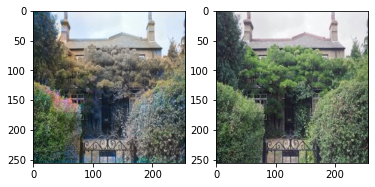

Time for batch  40 / 625 =  3.0629241466522217 , Loss Generator  =  8.234461784362793  , Loss Discriminator =  0.822826087474823
Time for batch  80 / 625 =  2.6815025806427 , Loss Generator  =  8.326534271240234  , Loss Discriminator =  1.4842321872711182
Time for batch  120 / 625 =  2.471750259399414 , Loss Generator  =  9.138257026672363  , Loss Discriminator =  0.8152244687080383
Time for batch  160 / 625 =  2.615412712097168 , Loss Generator  =  7.898712158203125  , Loss Discriminator =  0.9617903232574463
Time for batch  200 / 625 =  3.1921284198760986 , Loss Generator  =  7.735097885131836  , Loss Discriminator =  1.0540556907653809
Time for batch  240 / 625 =  3.2829582691192627 , Loss Generator  =  8.09266185760498  , Loss Discriminator =  0.998878002166748
Time for batch  280 / 625 =  2.9763529300689697 , Loss Generator  =  7.684797286987305  , Loss Discriminator =  2.004042863845825
Generated Image ---------------Ground Truth Image


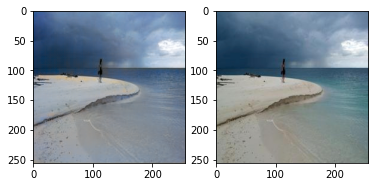

Time for batch  320 / 625 =  3.142512798309326 , Loss Generator  =  8.18212604522705  , Loss Discriminator =  1.4372012615203857
Time for batch  360 / 625 =  3.2657132148742676 , Loss Generator  =  7.438791275024414  , Loss Discriminator =  1.1592648029327393
Time for batch  400 / 625 =  2.261101722717285 , Loss Generator  =  6.531529426574707  , Loss Discriminator =  1.771701455116272
Time for batch  440 / 625 =  3.1792423725128174 , Loss Generator  =  6.489951133728027  , Loss Discriminator =  1.0917624235153198
Time for batch  480 / 625 =  2.5920205116271973 , Loss Generator  =  6.673313140869141  , Loss Discriminator =  1.1407546997070312
Time for batch  520 / 625 =  3.1004586219787598 , Loss Generator  =  8.439018249511719  , Loss Discriminator =  1.1448390483856201
Time for batch  560 / 625 =  2.970794200897217 , Loss Generator  =  8.92646598815918  , Loss Discriminator =  1.1359976530075073
Generated Image ---------------Ground Truth Image


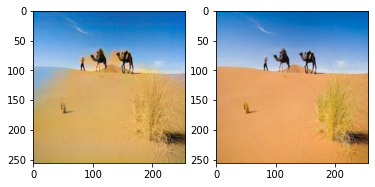

Time for batch  600 / 625 =  3.0438783168792725 , Loss Generator  =  6.328639507293701  , Loss Discriminator =  1.6259145736694336
Saving check point for  61  epoch 

 epoch  61  completed

 
 Generator Loss Plot


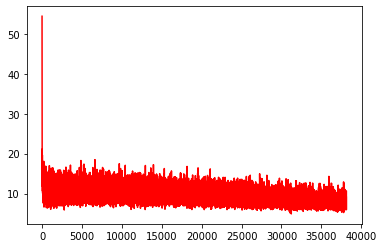



 Discriminator Loss Plot


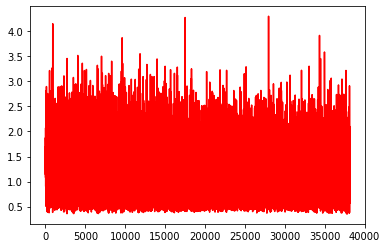

In [68]:
torch.autograd.set_detect_anomaly(True)
from google.colab.patches import cv2_imshow

D_BCE=nn.BCELoss()
G_BCE=nn.BCELoss()
L1=nn.L1Loss()
training = True
time_last = time.time()
while training:
  for i , (gray_imgs , lab_imgs ) in enumerate(train_loader):

    lab_imgs=Variable(lab_imgs.cuda().type(dtype)  )
    gray_imgs=Variable(gray_imgs.cuda().type(dtype)  )

    #update discriminator
    discriminator.zero_grad()
    out = discriminator(torch.cat((gray_imgs , lab_imgs) , 1 )) #Using Ground Truth Image
    out = torch.squeeze(out)
    loss_d_real = D_BCE( out , (0.9*torch.ones(cfg.batch_size ) ).cuda() ) #discriminator Binary Cross Entropy Loss for actual image
    fake_img = generator(gray_imgs).detach()
    out = discriminator(torch.cat((gray_imgs.detach() , fake_img) , 1).detach()) #Using Generated Image
    out =torch.squeeze(out)
    loss_d_fake = D_BCE( out,(torch.zeros(cfg.batch_size)).cuda()) #Discriminator BCE loss for fake generated image
    loss_d = loss_d_real + loss_d_fake
    loss_d.backward()
    loss_D.append(loss_d.item()) 
    optimizer_D.step() 

    #update Generator
    generator.zero_grad()
    fake_img = generator(gray_imgs)
    out = discriminator(torch.cat((gray_imgs , fake_img) , 1) )
    out = torch.squeeze(out)
    loss_g_fake= G_BCE( out ,(torch.ones(cfg.batch_size)).cuda())  #Binary Cross Entropy Loss for generator
    loss_g_l1 = cfg.lambd* L1(fake_img.view(fake_img.size(0),-1),lab_imgs.view(lab_imgs.size(0),-1)) #L1 loss 
    loss_g = loss_g_fake + loss_g_l1
    
    loss_g.backward()
    optimizer_G.step()
    loss_G.append(loss_g.item())
    time_this = time.time()
    batch_time = time_this-time_last
    if i%40==0:
      print("Time for batch " , i , "/", len(train_loader) , "= " , batch_time , ", Loss Generator  = " , loss_g.item() , ' , Loss Discriminator = ' , loss_d.item() )
      if i%7 == 0 :
        with torch.no_grad():
          print('Generated Image ---------------Ground Truth Image')
          f = plt.figure()
          f.add_subplot(1,2, 1)
          i1 = imfakeshow(torch.cat((gray_imgs[0] , fake_img[0]) , 0 ) , True ) 
          i2 = imfakeshow(torch.cat((gray_imgs[0] , lab_imgs[0]) , 0 ) , True )
          plt.imshow(i1)
          f.add_subplot(1,2, 2)
          plt.imshow(i2)
          plt.show(block=True)
          
    time_last = time.time()


  
  save_latest(generator , discriminator , optimizer_G , optimizer_D , step  ) #save weights
  save_loss(loss_G , loss_D)
  print('\n epoch ' , step , ' completed' )
  step+=1
  print('\n \n Generator Loss Plot')
  plt.plot(np.array(loss_G), 'r')
  plt.show()
  print('\n\n Discriminator Loss Plot')
  plt.plot(np.array(loss_D), 'r')
  plt.show()
  if step > cfg.epoch_ul: 
    break


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


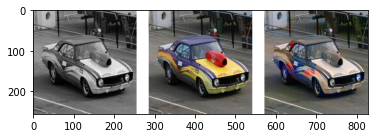

In [59]:
model = Generator().to(device)
model.eval()
cfg = set_config()
cfg.mode = 'test'
t1 = glob.glob(cfg.gpath+'G_epoch*')
checkpoint = torch.load(t1[0])
model.load_state_dict(checkpoint['state_dict'])  #loading trained weights


cfg.test_img = '/content/drive/MyDrive/colorization/test/i22.jpg' #setting test_img_path
fname = cfg.test_img.split('/')[-1]
fname = fname.split('.')[0]


with torch.no_grad():
  test_data=Places365_loader('test' , cfg.test_img )
  test_loader=DataLoader(test_data,1,shuffle=False,collate_fn=test_collate )
  for i,(gray_img , lab_img ) in enumerate(test_loader):
    lab_img =lab_img.cuda().type(dtype)
    gray_img=gray_img.cuda().type(dtype)
    fake_img= model(gray_img)
    imgrayshow(gray_img[0]  )
    imfakeshow(torch.cat((gray_img[0] , fake_img[0]) , 0 )  ) 
    imfakeshow(torch.cat((gray_img[0] , lab_img[0]) , 0 )  )
    
    
